# goal for this code：
1. find the correlations between score(using textblob) and other information(user_favourites & time)

## 'user_followers_count','user_friends_count','user_favourites_count' VS score

In [121]:
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

In [122]:
df_cor = df_final[['user_followers_count','user_friends_count','user_favourites_count','Polarity','Subjectivity']]
df_cor.sample(5)

,user_followers_count,user_friends_count,user_favourites_count,Polarity,Subjectivity
5200,1356,2573,8328,0.15,0.33
4249,15050,1431,10826,0.15,0.56
5462,379,789,929,-0.01,0.20
1530,202,339,22441,-0.05,0.00
3784,1854,1805,8280,-0.17,0.20


In [123]:
df_cor.isnull().sum()

user_followers_count     0
user_friends_count       0
user_favourites_count    0
Polarity                 0
Subjectivity             0
dtype: int64

### 先正态分布检验

In [124]:
df_cor.describe()

,user_followers_count,user_friends_count,user_favourites_count,Polarity,Subjectivity
count,6.528000e+03,6528.000000,6.528000e+03,6528.000000,6528.000000
mean,1.207172e+05,1952.749234,3.666834e+04,-0.022125,0.173381
std,2.210008e+06,6626.124028,6.946684e+04,0.151030,0.206546
min,0.000000e+00,0.000000,0.000000e+00,-1.000000,0.000000
25%,1.290000e+02,235.000000,2.562250e+03,-0.050000,0.000000
50%,5.160000e+02,639.500000,1.172500e+04,-0.050000,0.050000
75%,1.978500e+03,1793.000000,4.112500e+04,0.030000,0.330000
max,1.030626e+08,229046.000000,1.100976e+06,1.000000,1.000000


In [125]:
# 偏度
df_cor.skew()

user_followers_count     35.949109
user_friends_count       18.433673
user_favourites_count     4.917701
Polarity                  0.100018
Subjectivity              0.987606
dtype: float64

In [126]:
# 峰度
df_cor.kurtosis()

user_followers_count     1540.035378
user_friends_count        505.779203
user_favourites_count      37.617435
Polarity                    4.550202
Subjectivity                0.371489
dtype: float64

如果峰度绝对值小于10并且偏度绝对值小于3，则说明数据虽然不是绝对正态，但基本可接受为正态分布。

In [127]:
# Shapiro-Wilk检验(小样本  3⩽𝑛⩽50 )
def SW(X):
    result = stats.shapiro(X)
    return pd.Series(result, index=['SW', 'pvalue']).round(4)
df_test = df_cor.apply(SW)
df_test

,user_followers_count,user_friends_count,user_favourites_count,Polarity,Subjectivity
SW,0.0278,0.2101,0.5252,0.873,0.8103
pvalue,0.0000,0.0000,0.0000,0.000,0.0000


In [128]:
# 显著性检验，验证该随机变量是否符合正态分布
# 将p值与0.05比较，小于则可拒绝原假设，否则不能拒绝原假设
df_test.iloc[1,:] > 0.05

user_followers_count     False
user_friends_count       False
user_favourites_count    False
Polarity                 False
Subjectivity             False
Name: pvalue, dtype: bool

### 数据严重非正态，采用斯皮尔曼相关系数

In [129]:
correlations = df_cor.corr('spearman')
correlations

,user_followers_count,user_friends_count,user_favourites_count,Polarity,Subjectivity
user_followers_count,1.000000,0.770683,0.576522,0.050027,0.044800
user_friends_count,0.770683,1.000000,0.564361,0.026290,0.010066
user_favourites_count,0.576522,0.564361,1.000000,-0.017403,-0.004074
Polarity,0.050027,0.026290,-0.017403,1.000000,0.144181
Subjectivity,0.044800,0.010066,-0.004074,0.144181,1.000000


In [130]:
def PvalueGetSpearman(X, Y):
    return stats.spearmanr(X, Y)[1].round(4)
df_cor.corr(method=PvalueGetSpearman)

,user_followers_count,user_friends_count,user_favourites_count,Polarity,Subjectivity
user_followers_count,1.0000,0.0000,0.0000,0.0001,0.0003
user_friends_count,0.0000,1.0000,0.0000,0.0337,0.4161
user_favourites_count,0.0000,0.0000,1.0000,0.1598,0.7421
Polarity,0.0001,0.0337,0.1598,1.0000,0.0000
Subjectivity,0.0003,0.4161,0.7421,0.0000,1.0000


In [131]:
df_cor.corr(method=PvalueGetSpearman) > 0.05

,user_followers_count,user_friends_count,user_favourites_count,Polarity,Subjectivity
user_followers_count,True,False,False,False,False
user_friends_count,False,True,False,False,True
user_favourites_count,False,False,True,True,True
Polarity,False,False,True,True,False
Subjectivity,False,True,True,False,True


conclusion: CORRELATIONS exist in
1. user_friends_count VS Subjectivity
2. user_favourites_count VS Polarity
3. user_favourites_count VS Subjectivity	

## 用seaborn绘制热力图

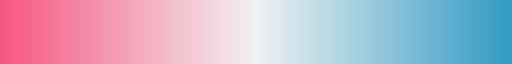

In [132]:
# 正常显示汉字和负号
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

sns.diverging_palette(0, 230, 90, 60, as_cmap=True)

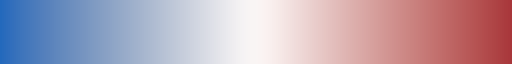

In [133]:
sns.color_palette('vlag', as_cmap=True)

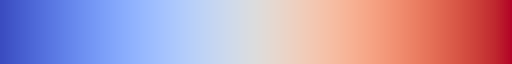

In [134]:
sns.color_palette('coolwarm', as_cmap=True)

In [135]:
# 绘制发散调色板用作cmap
# cmap = sns.diverging_palette(0, 230, 90, 60, as_cmap=True)
cmap = sns.color_palette('vlag', as_cmap=True)
# cmap = sns.color_palette('coolwarm', as_cmap=True)

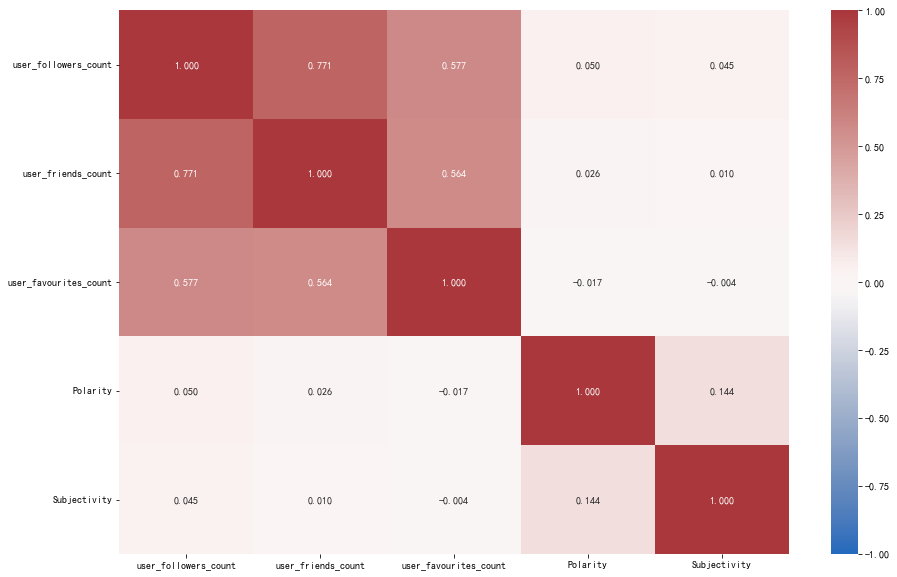

In [136]:
# 在heatmap(square=False)时可以调整图片大小，x、y轴标签的方向
plt.figure(figsize=(15,10))
ax = sns.heatmap(correlations, vmin=-1, vmax=1, cmap=cmap, annot=True, fmt='.3f')
ax.set_xticklabels(df_cor.columns, rotation='horizontal')
ax.set_yticklabels(df_cor.columns, rotation='horizontal')
plt.savefig('C:/Users/86180/Desktop/IC-DS/GROUP PROJECT/image/cor_Part1')
plt.show()

## 用定序数据

In [145]:
# Bucketing the Polarity scores into Medium, lower and Higher buckets using Lambda expresisno
df_final['Subjectivity_buckets'] = df_final['Subjectivity'].apply(
    lambda x: 'objective' if x<=0.05 else 'subjective')
# print(df_final.shape[0])
# calculate the portions of each busket
df_final['Subjectivity_buckets'].value_counts(normalize = True)*100

objective     50.122549
subjective    49.877451
Name: Subjectivity_buckets, dtype: float64

In [148]:
df_final['Subscore']=df_final['Subjectivity_buckets'].apply(lambda x:1 if x=='subjective' else 0)
df_final['Subscore'].sample(5)

1154    1
2283    1
1218    0
3265    0
5731    0
Name: Subscore, dtype: int64

In [158]:
df_cor = df_final[['user_favourites_count','Score','Subscore']]

corr = df_cor.corr('spearman')
corr

,user_favourites_count,Score,Subscore
user_favourites_count,1.000000,-0.017564,-0.010273
Score,-0.017564,1.000000,0.489013
Subscore,-0.010273,0.489013,1.000000


In [156]:
def PvalueGetSpearman(X, Y):
    return stats.spearmanr(X, Y)[1].round(4)
df_cor.corr(method=PvalueGetSpearman)

,user_favourites_count,Score,Subscore
user_favourites_count,1.0000,0.1559,0.4066
Score,0.1559,1.0000,0.0000
Subscore,0.4066,0.0000,1.0000


In [157]:
df_cor.corr(method=PvalueGetSpearman)> 0.05

,user_favourites_count,Score,Subscore
user_favourites_count,True,True,True
Score,True,True,False
Subscore,True,False,True


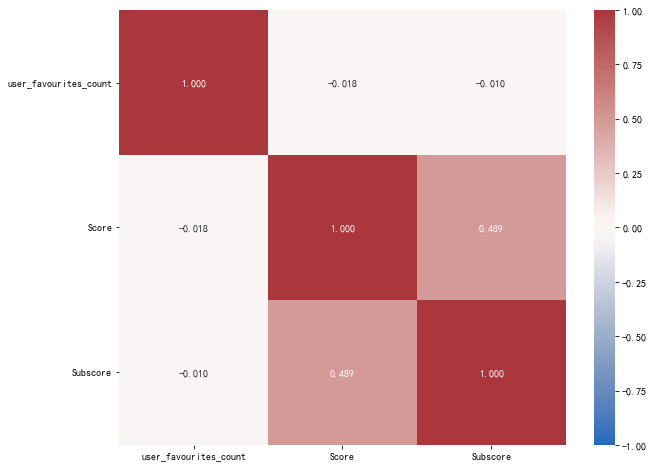

In [163]:
# 在heatmap(square=False)时可以调整图片大小，x、y轴标签的方向
plt.figure(figsize=(10,8))
ax = sns.heatmap(corr, vmin=-1, vmax=1, cmap=cmap, annot=True, fmt='.3f')
ax.set_xticklabels(df_cor.columns, rotation='horizontal')
ax.set_yticklabels(df_cor.columns, rotation='horizontal')
plt.savefig('C:/Users/86180/Desktop/IC-DS/GROUP PROJECT/image/corr_Part1')
plt.show()

# time vs score

## 1. combine all data

In [2]:
import pandas as pd

df1 = pd.read_csv('C:/Users/86180/Desktop/IC-DS/GROUP PROJECT/cleaned_data/part1.csv')
df2 = pd.read_csv('C:/Users/86180/Desktop/IC-DS/GROUP PROJECT/cleaned_data/part2.csv')
df3 = pd.read_csv('C:/Users/86180/Desktop/IC-DS/GROUP PROJECT/cleaned_data/part3.csv')
df4 = pd.read_csv('C:/Users/86180/Desktop/IC-DS/GROUP PROJECT/cleaned_data/part4.csv')
df5 = pd.read_csv('C:/Users/86180/Desktop/IC-DS/GROUP PROJECT/cleaned_data/part5.csv'
                  ,low_memory=False
                 )
df6 = pd.read_csv('C:/Users/86180/Desktop/IC-DS/GROUP PROJECT/cleaned_data/part6.csv')


In [59]:
df1 = pd.read_csv('C:/Users/86180/Desktop/IC-DS/GROUP PROJECT/cleaned_data/part1.csv')
df1.head()

,coordinates,created_at,hashtags,media,urls,favorite_count,id,in_reply_to_screen_name,in_reply_to_status_id,in_reply_to_user_id,...,user_followers_count,user_friends_count,user_listed_count,user_location,user_name,user_screen_name,user_statuses_count,user_time_zone,user_urls,user_verified
0,NaN,Sat May 21 21:51:16 +0000 2022,NaN,NaN,https://warroom.org/2022/05/21/episode-1874-wh...,28,1528131335742705665,NaN,NaN,NaN,...,57368,835,1453,Global -- Currently on Earth,Michael Yon,Michael_Yon,59871,NaN,http://www.michaelyon.com,False
1,NaN,Sat May 21 22:25:48 +0000 2022,NaN,NaN,NaN,0,1528140025623646208,imispgh,1.528139e+18,1.492808e+07,...,787,4852,9,Origin🌳US + in 155 countries.,@AILovesTech®️🔑🚘,AILoves_Jackie9,21789,NaN,https://twitter.com/@T_W_T_R_Wallet,False
2,NaN,Sat May 21 22:24:39 +0000 2022,NaN,NaN,NaN,1,1528139737957126144,NaN,NaN,NaN,...,180,899,2,NaN,Mikey,MikeyNYI,6435,NaN,NaN,False
3,NaN,Sat May 21 22:27:59 +0000 2022,NaN,NaN,NaN,0,1528140577320996864,PeteUK7,1.528108e+18,1.235378e+18,...,2213,3077,48,Unceded Lək̓ʷəŋən Nations Land,David D. 🟧 🪶 🟧,answerallman,334792,NaN,https://twitter.com/answerallman/status/134144...,False
4,NaN,Sat May 21 22:24:11 +0000 2022,NaN,NaN,NaN,2,1528139620176625664,vancemurphy,1.528060e+18,2.455673e+08,...,4193,4994,3,NaN,MAGA B,MAGAB07910508,36256,NaN,NaN,False


In [3]:
df = pd.concat([df1, df2,df3,df4,df5,df6], ignore_index=True)


In [7]:
df.to_csv('C:/Users/86180/Desktop/IC-DS/GROUP PROJECT/cleaned_data/combine.csv')

In [3]:
df.shape

(184138, 35)

In [4]:
from datetime import datetime

content = df[['created_at','text']]
content['created_at']= content['created_at'].apply(lambda dtime: datetime.strftime(datetime.strptime(dtime,'%a %b %d %H:%M:%S +0000 %Y'), '%Y-%m-%d %H:%M:%S'))
content['created_at']= pd.to_datetime(content['created_at'])
content

C:\Users\86180\AppData\Local\Temp\ipykernel_13320\1932849947.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  content['created_at']= content['created_at'].apply(lambda dtime: datetime.strftime(datetime.strptime(dtime,'%a %b %d %H:%M:%S +0000 %Y'), '%Y-%m-%d %H:%M:%S'))
C:\Users\86180\AppData\Local\Temp\ipykernel_13320\1932849947.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  content['created_at']= pd.to_datetime(content['created_at'])


,created_at,text
0,2022-05-21 21:51:16,Watch the progressive monkeys run out screamin...
1,2022-05-21 22:25:48,When you have Bill Gates shorting Tesla for ...
2,2022-05-21 22:24:39,"Monkey pox as reported by Reuters \n\n“Gay, bi..."
3,2022-05-21 22:27:59,Hey Pete\nPeople are crazy 'Busy'\nWe can't ...
4,2022-05-21 22:24:11,"_tx _FDA Well, you know the new thing is..."
...,...,...
184133,2022-07-23 00:00:07,Monkeypox: US confirms first two cases in chil...
184134,2022-07-23 00:00:00,With demand rising for Bavarian Nordic’s small...
184135,2022-07-23 00:00:18,"For our local response, starting tomorrow ..."
184136,2022-07-23 00:00:23,Monkeypox Be Not Proud (7-22-22)


In [5]:
import nltk
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

def sentiment(df):
    sid_obj = SentimentIntensityAnalyzer()
    vader =[]
    for col in df['text']:
        sentiment_dict = sid_obj.polarity_scores(col)
        compound = sentiment_dict['compound']
        vader.append(compound)
    df.insert(df.shape[1], 'sentiment', vader)
    return df

sort_time = sentiment(content).sort_values(by="created_at")

In [7]:
#sort_time = content.sort_values(by="created_at")
vader = sort_time.reset_index(drop=True)
vader

,created_at,text,sentiment
0,2011-05-13 00:47:54,I HAVE NEVER AND WILL NEVER APOLOGISE FOR MY S...,0.7198
1,2012-04-27 04:16:52,"Monkeypox on Delta 3163, quarantined in Chicag...",-0.6808
2,2018-06-22 17:24:47,If you are terrified of confined spaces and fa...,0.0000
3,2019-05-18 16:37:43,We have a lot of photographs in our collection...,-0.1154
4,2019-05-18 16:37:43,We have a lot of photographs in our collection...,-0.1154
...,...,...,...
184133,2022-07-23 23:59:47,There is no mechanism that would encourage t...,-0.1225
184134,2022-07-23 23:59:48,U.N. global health chief declares monkeypox a ...,-0.3818
184135,2022-07-23 23:59:50,WHO let the pox out ? WHO..WHO.. WHO..WHO ...,0.0000
184136,2022-07-23 23:59:50,_ape but stay away from me if yall apes h...,0.8462


In [8]:
vader.to_csv('C:/Users/86180/Desktop/IC-DS/GROUP PROJECT/vader.csv')

## textblob

In [9]:
from textblob import TextBlob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import emoji

In [10]:
textblob = df[['created_at','text']]
textblob['text'] = textblob['text'].astype(str).apply(lambda x: emoji.demojize(x))

C:\Users\86180\AppData\Local\Temp\ipykernel_13320\640970743.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  textblob['text'] = textblob['text'].astype(str).apply(lambda x: emoji.demojize(x))


In [11]:
pd.options.mode.chained_assignment = None

textblob['sentiment'] = textblob['text'].apply(lambda review: TextBlob(review).sentiment) 
textblob['Polarity'] = textblob['sentiment'].apply(lambda x: round(x[0],2)) 
textblob['Subjectivity'] = textblob['sentiment'].apply(lambda x: round(x[1],2)) 
textblob.head()

,created_at,text,sentiment,Polarity,Subjectivity
0,Sat May 21 21:51:16 +0000 2022,Watch the progressive monkeys run out screamin...,"(-0.1625, 0.3875)",-0.16,0.39
1,Sat May 21 22:25:48 +0000 2022,When you have Bill Gates shorting Tesla for ...,"(-0.04583333333333334, 0.058333333333333334)",-0.05,0.06
2,Sat May 21 22:24:39 +0000 2022,"Monkey pox as reported by Reuters \n\n“Gay, bi...","(0.08166666666666667, 0.30833333333333335)",0.08,0.31
3,Sat May 21 22:27:59 +0000 2022,Hey Pete\nPeople are crazy 'Busy'\nWe can't ...,"(-0.1375, 0.55)",-0.14,0.55
4,Sat May 21 22:24:11 +0000 2022,"_tx _FDA Well, you know the new thing is...","(0.12402597402597403, 0.33008658008658004)",0.12,0.33


In [13]:
textblob['created_at']= textblob['created_at'].apply(lambda dtime: datetime.strftime(datetime.strptime(dtime,'%a %b %d %H:%M:%S +0000 %Y'), '%Y-%m-%d %H:%M:%S'))
textblob['created_at']= pd.to_datetime(textblob['created_at'])
TB = textblob.sort_values(by="created_at").reset_index(drop=True)
TB

,created_at,text,sentiment,Polarity,Subjectivity
0,2011-05-13 00:47:54,I HAVE NEVER AND WILL NEVER APOLOGISE FOR MY S...,"(0.48333333333333334, 0.5416666666666667)",0.48,0.54
1,2012-04-27 04:16:52,"Monkeypox on Delta 3163, quarantined in Chicag...","(0.0, 0.3333333333333333)",0.00,0.33
2,2018-06-22 17:24:47,If you are terrified of confined spaces and fa...,"(0.7, 0.6000000000000001)",0.70,0.60
3,2019-05-18 16:37:43,We have a lot of photographs in our collection...,"(0.22817460317460314, 0.5059523809523809)",0.23,0.51
4,2019-05-18 16:37:43,We have a lot of photographs in our collection...,"(0.22817460317460314, 0.5059523809523809)",0.23,0.51
...,...,...,...,...,...
184133,2022-07-23 23:59:47,There is no mechanism that would encourage t...,"(0.1375, 0.33333333333333337)",0.14,0.33
184134,2022-07-23 23:59:48,U.N. global health chief declares monkeypox a ...,"(0.0, 0.0)",0.00,0.00
184135,2022-07-23 23:59:50,WHO let the pox out ? WHO..WHO.. WHO..WHO ...,"(0.0, 0.0)",0.00,0.00
184136,2022-07-23 23:59:50,_ape but stay away from me if yall apes h...,"(0.0, 0.0)",0.00,0.00


In [14]:
TB.to_csv('C:/Users/86180/Desktop/IC-DS/GROUP PROJECT/textblob.csv')

In [20]:
TB.drop(columns=['sentiment'],inplace =True)

In [22]:
TB['vader'] = vader['sentiment']
TB

,created_at,text,Polarity,Subjectivity,vader
0,2011-05-13 00:47:54,I HAVE NEVER AND WILL NEVER APOLOGISE FOR MY S...,0.48,0.54,0.7198
1,2012-04-27 04:16:52,"Monkeypox on Delta 3163, quarantined in Chicag...",0.00,0.33,-0.6808
2,2018-06-22 17:24:47,If you are terrified of confined spaces and fa...,0.70,0.60,0.0000
3,2019-05-18 16:37:43,We have a lot of photographs in our collection...,0.23,0.51,-0.1154
4,2019-05-18 16:37:43,We have a lot of photographs in our collection...,0.23,0.51,-0.1154
...,...,...,...,...,...
184133,2022-07-23 23:59:47,There is no mechanism that would encourage t...,0.14,0.33,-0.1225
184134,2022-07-23 23:59:48,U.N. global health chief declares monkeypox a ...,0.00,0.00,-0.3818
184135,2022-07-23 23:59:50,WHO let the pox out ? WHO..WHO.. WHO..WHO ...,0.00,0.00,0.0000
184136,2022-07-23 23:59:50,_ape but stay away from me if yall apes h...,0.00,0.00,0.8462


In [23]:
TB.to_csv('C:/Users/86180/Desktop/IC-DS/GROUP PROJECT/vader_textblob.csv')

In [226]:
cor_time = vader[['created_at','sentiment']]
cor_time.shape

(184138, 2)

In [237]:
(cor_time['created_at']<='2022-05-7 23:59:59').value_counts()

False    184021
True        114
Name: created_at, dtype: int64

## 手动分阶段作图

5.7英国英格兰发现一例猴痘感染者。

5.18美国发现一例猴痘感染者

5.20美国有发现两例

5.21日，德国首都柏林出现2例猴痘确诊病例。截至20日，法国、瑞典和荷兰各自确认了最近的一例病例，加拿大报告了2例，比利时和意大利报告了3例。英国的病例总数高达20例，葡萄牙为 23 例，西班牙为 30 例。澳大利亚和以色列21日各报告了 1 例病例，均发生在自西欧地区返回本国的旅行者身上。



In [272]:
t1 = cor_time[:114] # 2011- 2022/05/07
t2 = cor_time[114:126]# 2022/05/07--05/18
t3 = cor_time[126:1715]# 2022/05/18-2022/05/20
t4 = cor_time[1715:9378]# 2022/05/20

t5 = cor_time[9378:17177]# 2022/5/25-2022/05/30
t6 = cor_time[17177:23138]# 2022/05/30-2022/06/3
t7 = cor_time[23138:28571]# 2022/0603-2022/06/6
t8 = cor_time[28571:36126]# 2022/0606-2022/06/10

t9 = cor_time[36126:44977]# 2022/06/10-2022/06/15
t10 = cor_time[44977:52670]# 2022/06/15-2022/06/20
t11 = cor_time[52670:63154]# 2022/06/20-2022/06/25
t12 = cor_time[63154:75828]# 2022/06/25-2022/06/30

t13 = cor_time[75828:82559]# 2022/06/30-2022/07/10
t14 = cor_time[82559:113358]# 2022/07/10-2022/07/15
t15 = cor_time[113358:128077]# 2022/07/15-2022/07/20
t16 = cor_time[128077:]# 2022/07/20-2022/07/23

In [290]:
time_list = [t1,t2,t3,t4,t5,t6,t7,t8,t9,t10,t11,t12,t13,t14,t15,t16]
label_list = ['2011- 2022/05/07','2022/05/07-2022/05/18','2022/05/18-2022/05/20','2022/05/20-2022/05/25',
              '2022/05/25-2022/05/30','2022/05/30-2022/06/03','2022/06/03-2022/06/06','2022/06/06-2022/06/09',
             '2022/06/10-2022/06/15','2022/06/15-2022/06/20','2022/06/20-2022/06/25','2022/06/25-2022/06/30',
             '2022/06/30-2022/07/10','2022/07/10-2022/07/15','2022/07/15-2022/07/20','2022/07/20-2022/07/23']
sent_mean = []
for i in range(16):
    sent_mean.append(time_list[i]['sentiment'].mean())
sent_mean

[-0.006765789473684209,
 0.1762166666666667,
 -0.030911516677155488,
 -0.033315137674539995,
 -0.012733093986408602,
 0.002412598557289057,
 -0.0015561200073623991,
 0.010700529450694874,
 -0.009202225737204868,
 -0.02842368386845175,
 -0.0009986074017550907,
 -0.006678041660091506,
 -0.0007409300252562653,
 -0.01866186239813001,
 -0.0325144982675454,
 -0.10216686824361965]

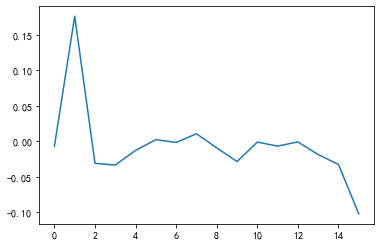

In [292]:
plt.plot(sent_mean)
#plt.xlabel(label_list)
#plt.ylabel('sentiment')

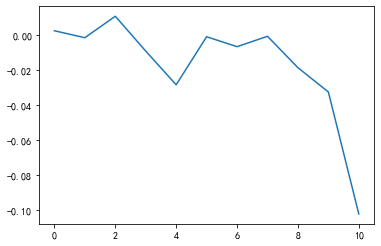

In [297]:
# 研究从六月起的
df_time = sent_mean[5:]
df_list = label_list[5:]
plt.plot(df_time)

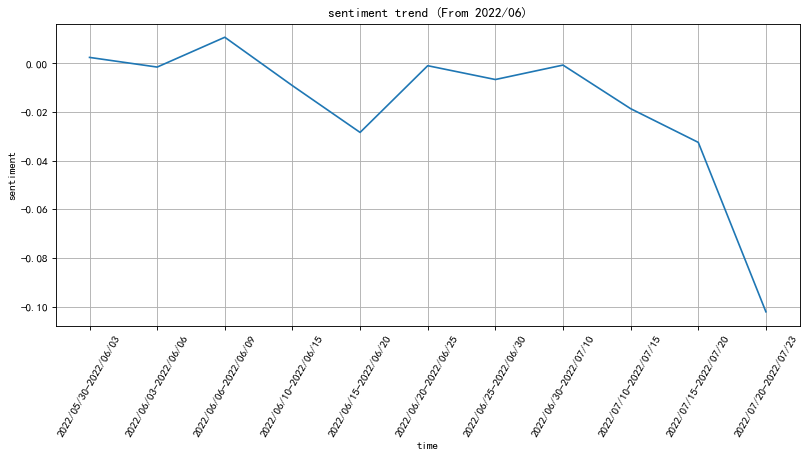

In [312]:
# 绘制时序图
plt.figure(figsize=(12, 5), dpi=80)
plt.plot(df_list, df_time)
plt.title('sentiment trend (From 2022/06)')
plt.xticks(rotation=60)
plt.xlabel("time")
plt.ylabel("sentiment")
plt.grid()
plt.savefig('C:/Users/86180/Desktop/IC-DS/GROUP PROJECT/image/sentiment trend')
plt.show()

## spearman相关系数

In [307]:
df_ = pd.DataFrame(df_time).reset_index(inplace=False)
df_.columns = ['stage','sentiment']
cor_ =df_.corr('spearman')
cor_

,stage,sentiment
stage,1.000000,-0.681818
sentiment,-0.681818,1.000000


### 显著负相关

In [352]:
(cor_time['created_at']<=('2022-05-06 23:59:59')).value_counts()[1]

114

## 每日平均数据

In [34]:
# 5月
pre = 114
May_list = []
for i in range(7,31):
    now = (cor_time['created_at']<=('2022-05-'+str(i)+' 23:59:59')).value_counts()[1]
    May_list.append( cor_time[pre:now].mean())
    pre = now
May = pd.DataFrame(May_list).dropna()
len(May_list)

24

In [337]:
## 如果从六月起，每天算一次平均
(cor_time['created_at']<=('2022-05-31 23:59:59')).value_counts()[1]

19238

In [362]:
# 6月
pre = 19238
June_list = []
for i in range(1,31):
    now = (cor_time['created_at']<=('2022-06-'+str(i)+' 23:59:59')).value_counts()[1]
    June_list.append( cor_time[pre:now].mean())
    pre = now

June = pd.DataFrame(June_list).dropna()
len(June_list)

30

In [345]:
(cor_time['created_at']<=('2022-06-30 23:59:59')).value_counts()[1]

75828

In [363]:
# 7月
pre = 75828
July_list = []
for i in range(1,32):
    now = (cor_time['created_at']<=('2022-07-'+str(i)+' 23:59:59')).value_counts()[1]
    July_list.append( cor_time[pre:now].mean())
    pre = now
July = pd.DataFrame(July_list).dropna()
len(July_list)
#July_list

31

In [366]:
day = pd.concat([May,June,July], ignore_index=True)

In [369]:
day.to_csv('C:/Users/86180/Desktop/IC-DS/GROUP PROJECT/day_score.csv')

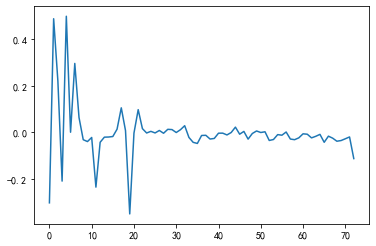

In [368]:
plt.plot(day)

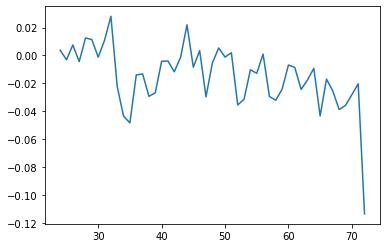

In [37]:
plt.plot(day['sentiment'][24:])

In [3]:
day = pd.read_csv('C:/Users/86180/Desktop/IC-DS/GROUP PROJECT/day_score.csv')
cor_time =pd.read_csv('C:/Users/86180/Desktop/IC-DS/GROUP PROJECT/combine.csv') 

In [28]:
# 5月
pre = 114
May_list = []
for i in range(7,31):
    now = (cor_time['created_at']<=('2022-05-'+str(i)+' 23:59:59')).value_counts()[1]
    May_list.append( cor_time['sentiment'][pre:now].var())
    pre = now
May = pd.DataFrame(May_list).dropna()
len(May)

16

In [29]:
# 6月
pre = 19238
June_list = []
for i in range(1,31):
    now = (cor_time['created_at']<=('2022-06-'+str(i)+' 23:59:59')).value_counts()[1]
    June_list.append( cor_time['sentiment'][pre:now].var())
    pre = now

June = pd.DataFrame(June_list).dropna()
len(June)

24

In [30]:
# 7月
pre = 75828
July_list = []
for i in range(1,32):
    now = (cor_time['created_at']<=('2022-07-'+str(i)+' 23:59:59')).value_counts()[1]
    July_list.append( cor_time['sentiment'][pre:now].var())
    pre = now
July = pd.DataFrame(July_list).dropna()
len(July)
#July_list

16

In [26]:
var_ = pd.concat([May,June,July], ignore_index=True)
var_.shape

(56, 1)

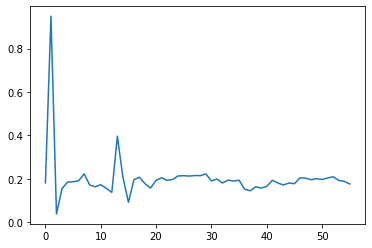

In [27]:
plt.plot(var_)

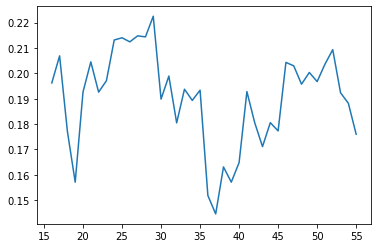

In [33]:
# 6月起
plt.plot(var_[16:])

In [ ]:
# 时间序列分析--灰色预测（到时候让队友用那个模型进行预测？)


### 对平均值对六月后数据图像拟合

In [44]:
# 使用polyfit方法
x1 = np.arange(1,day['sentiment'][24:].shape[0]+1,1)
y1 = day['sentiment'][24:]
z1 = np.polyfit(x1, y1, 5)
# 使用poly1d方法获得多项式系数,按照阶数由高到低排列
p1 = np.poly1d(z1)
# 打印拟合多项式
print(p1)
# 求对应x的各项拟合函数值
fx1 = p1(x1)

            5             4             3             2
-7.379e-09 x + 8.648e-07 x - 3.855e-05 x + 0.0008071 x - 0.008027 x + 0.0208


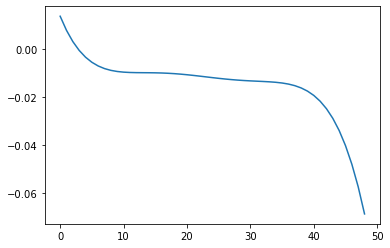

In [45]:
plt.plot(fx1)

In [55]:
# 使用polyfit方法
x1 = np.arange(1,var_[16:].shape[0]+1,1)
y1 = var_[16:][0]
z1 = np.polyfit(x1, y1, 5)
# 使用poly1d方法获得多项式系数,按照阶数由高到低排列
p1 = np.poly1d(z1)
# 打印拟合多项式
print(p1)
# 求对应x的各项拟合函数值
fx1 = p1(x1)

            5             4             3            2
-7.776e-08 x + 7.316e-06 x - 0.0002339 x + 0.002892 x - 0.01143 x + 0.2011


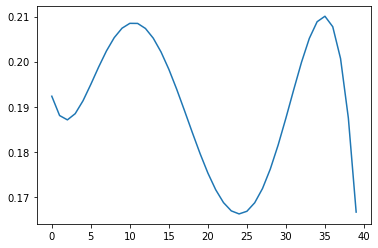

In [56]:
plt.plot(fx1)

### 拟合优度计算

In [57]:
def __sst(y_no_fitting):
    """
    计算SST(total sum of squares) 总平方和
    :param y_no_predicted: List[int] or array[int] 待拟合的y
    :return: 总平方和SST
    """
    y_mean = sum(y_no_fitting) / len(y_no_fitting)
    s_list =[(y - y_mean)**2 for y in y_no_fitting]
    sst = sum(s_list)
    return sst


def __ssr(y_fitting, y_no_fitting):
    """
    计算SSR(regression sum of squares) 回归平方和
    :param y_fitting: List[int] or array[int]  拟合好的y值
    :param y_no_fitting: List[int] or array[int] 待拟合y值
    :return: 回归平方和SSR
    """
    y_mean = sum(y_no_fitting) / len(y_no_fitting)
    s_list =[(y - y_mean)**2 for y in y_fitting]
    ssr = sum(s_list)
    return ssr


def __sse(y_fitting, y_no_fitting):
    """
    计算SSE(error sum of squares) 残差平方和
    :param y_fitting: List[int] or array[int] 拟合好的y值
    :param y_no_fitting: List[int] or array[int] 待拟合y值
    :return: 残差平方和SSE
    """
    s_list = [(y_fitting[i] - y_no_fitting[i])**2 for i in range(len(y_fitting))]
    sse = sum(s_list)
    return sse


def goodness_of_fit(y_fitting, y_no_fitting):
    """
    计算拟合优度R^2
    :param y_fitting: List[int] or array[int] 拟合好的y值
    :param y_no_fitting: List[int] or array[int] 待拟合y值
    :return: 拟合优度R^2
    """
    SSR = __ssr(y_fitting, y_no_fitting)
    SST = __sst(y_no_fitting)
    rr = SSR /SST
    return rr


In [ ]:
# polyfit的优度(data1-5次拟合)
RR_mean=goodness_of_fit(fx1,y1)
RR_mean

In [58]:
# polyfit的优度(data1-5次拟合)
RR_var=goodness_of_fit(fx1,y1)
RR_var

0.5893832925949681